In [1]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

## Init Data

In [2]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
weights, x, c = spo.data.knapsack.genData(n+1000, p, m, deg=deg, cor=False)

In [3]:
weights

array([6, 6, 6, 7, 3, 5, 7, 4, 6, 7, 3, 6, 3, 3, 7, 6, 3, 7, 7, 6, 3, 4,
       6, 3, 5, 6, 3, 3, 4, 3, 4, 3, 6, 7, 4, 4, 6, 4, 4, 5, 7, 6, 3, 3,
       7, 5, 4, 4])

In [4]:
# convert max into min
c = - c

## Optimization model 

In [5]:
# capacity
cap = 30

In [6]:
ks_model = spo.model.knapsackModel(weights, cap)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


In [7]:
# solve
ks_model.setObj([-1 for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Obj: -10.0
4
10
13
16
26
27
29
31
42
43


## Data Loader 

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [9]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [10]:
# get training data set
ks_dataset_train = spo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.05it/s]


In [11]:
# get test data set
ks_dataset_test = spo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 200.10it/s]


In [12]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [13]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [14]:
x.shape

torch.Size([32, 5])

In [15]:
c.shape

torch.Size([32, 48])

In [16]:
w.shape

torch.Size([32, 48])

In [17]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [20]:
# build model
twostage_model = spo.twostage.sklearnPred(reg, ks_model)

In [21]:
# training
twostage_model.fit(ks_dataset_train.x, ks_dataset_train.c)

In [22]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.x)

In [23]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.c[i]
    z_true_i = ks_dataset_test.z[i,0]
    truespo += spo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.z.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.z.sum()) * 100))

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.52it/s]


Normalized true SPO Loss: 2.09%
Normalized unambiguous SPO Loss: 2.09%


In [24]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: 2.73, 7.06, 13.91, 2.73, 6.00, 10.63, 7.79, 10.89, 6.59, 7.06, 10.01, 3.78, 10.63, 13.83, 2.73, 13.16, 7.88, 7.27, 13.16, 7.88, 6.59, 13.91, 13.16, 3.96, 5.43, 7.06, 3.96, 2.73, 7.06, 17.33, 7.10, 9.77, 10.82, 11.26, 14.18, 14.32, 1.56, 5.43, 1.56, 17.33, 5.43, 6.00, 10.01, 0.43, 2.73, 5.43, 17.33, 8.19
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

Sample

## Linear Regression from PyTorch

In [25]:
from torch import nn

In [26]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [27]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [28]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [29]:
# init SPO+ loss
criterion = spo.func.SPOPlus()

In [30]:
# train model
num_epochs = 200
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(ks_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  41.1494, True SPO Loss:  8.4499%, Unambiguous SPO Loss:  8.4499%
Epoch  20, Loss:  23.2651, True SPO Loss:  2.2808%, Unambiguous SPO Loss:  2.2808%
Epoch  30, Loss:  32.3797, True SPO Loss:  1.4049%, Unambiguous SPO Loss:  1.4049%
Epoch  40, Loss:   4.1790, True SPO Loss:  0.8168%, Unambiguous SPO Loss:  0.8168%
Epoch  50, Loss:   1.7077, True SPO Loss:  0.6366%, Unambiguous SPO Loss:  0.6366%
Epoch  60, Loss:   5.0745, True SPO Loss:  0.5823%, Unambiguous SPO Loss:  0.5823%
Epoch  70, Loss:   1.4560, True SPO Loss:  0.4699%, Unambiguous SPO Loss:  0.4699%
Epoch  80, Loss:   1.8350, True SPO Loss:  0.4166%, Unambiguous SPO Loss:  0.4166%
Epoch  90, Loss:   3.0775, True SPO Loss:  0.4060%, Unambiguous SPO Loss:  0.4060%
Epoch 100, Loss:   3.8860, True SPO Loss:  0.3856%, Unambiguous SPO Loss:  0.3856%
Epoch 110, Loss:   0.4503, True SPO Loss:  0.3769%, Unambiguous SPO Loss:  0.3769%
Epoch 120, Loss:   9.7379, True SPO Loss:  0.3459%, Unambiguous SPO Loss:  0.3459%
Epoc

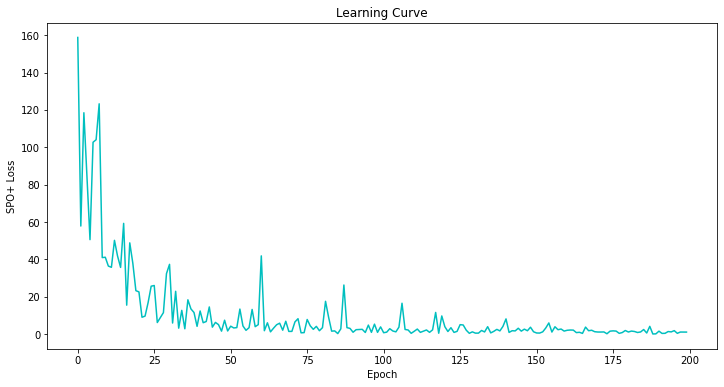

In [31]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

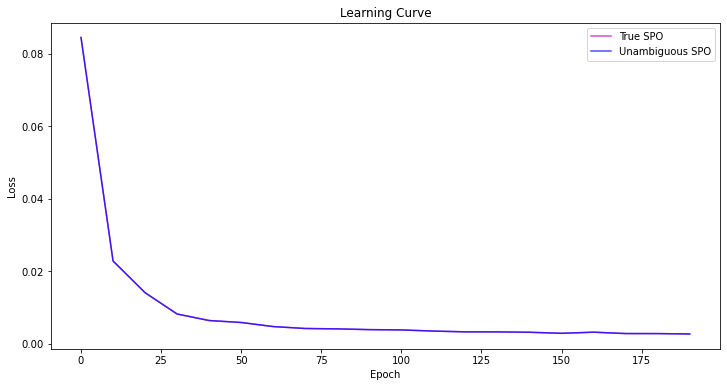

In [32]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [33]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.27%
Normalized unambiguous SPO Loss: 0.27%


In [34]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: 2.73, 7.06, 13.91, 2.73, 6.00, 10.63, 7.79, 10.89, 6.59, 7.06, 10.01, 3.78, 10.63, 13.83, 2.73, 13.16, 7.88, 7.27, 13.16, 7.88, 6.59, 13.91, 13.16, 3.96, 5.43, 7.06, 3.96, 2.73, 7.06, 17.33, 7.10, 9.77, 10.82, 11.26, 14.18, 14.32, 1.56, 5.43, 1.56, 17.33, 5.43, 6.00, 10.01, 0.43, 2.73, 5.43, 17.33, 8.19
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

Sample

## SPO+ with Regularization

In [35]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [36]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [37]:
# init SPO+ loss
criterion = spo.func.SPOPlus()

In [38]:
# train model
num_epochs = 200
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(ks_model, cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  59.0940, True SPO Loss:  5.9492%, Unambiguous SPO Loss:  5.9492%
Epoch  20, Loss:  23.3293, True SPO Loss:  1.9766%, Unambiguous SPO Loss:  1.9766%
Epoch  30, Loss:  23.7879, True SPO Loss:  1.1453%, Unambiguous SPO Loss:  1.1453%
Epoch  40, Loss:  19.6281, True SPO Loss:  0.7335%, Unambiguous SPO Loss:  0.7335%
Epoch  50, Loss:   3.0497, True SPO Loss:  0.5833%, Unambiguous SPO Loss:  0.5833%
Epoch  60, Loss:   6.8927, True SPO Loss:  0.5135%, Unambiguous SPO Loss:  0.5135%
Epoch  70, Loss:   2.7649, True SPO Loss:  0.4544%, Unambiguous SPO Loss:  0.4544%
Epoch  80, Loss:   8.2732, True SPO Loss:  0.4234%, Unambiguous SPO Loss:  0.4234%
Epoch  90, Loss:   5.5566, True SPO Loss:  0.3992%, Unambiguous SPO Loss:  0.3992%
Epoch 100, Loss:   0.9542, True SPO Loss:  0.3633%, Unambiguous SPO Loss:  0.3633%
Epoch 110, Loss:   4.0421, True SPO Loss:  0.3750%, Unambiguous SPO Loss:  0.3750%
Epoch 120, Loss:   1.5546, True SPO Loss:  0.3575%, Unambiguous SPO Loss:  0.3575%
Epoc

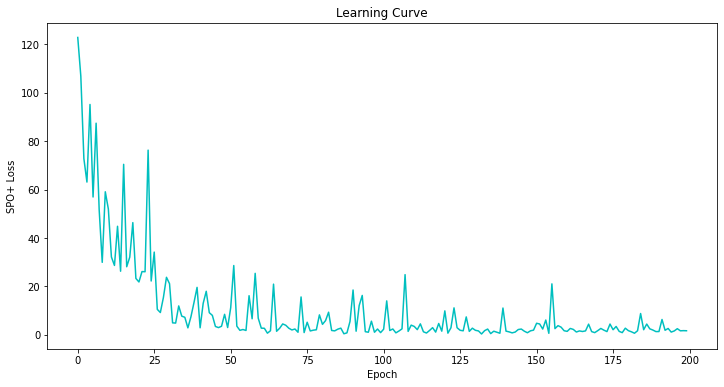

In [39]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

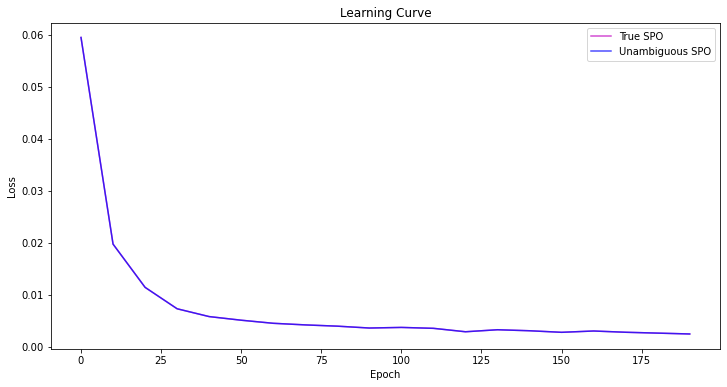

In [40]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [41]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.25%
Normalized unambiguous SPO Loss: 0.25%


In [42]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: 2.73, 7.06, 13.91, 2.73, 6.00, 10.63, 7.79, 10.89, 6.59, 7.06, 10.01, 3.78, 10.63, 13.83, 2.73, 13.16, 7.88, 7.27, 13.16, 7.88, 6.59, 13.91, 13.16, 3.96, 5.43, 7.06, 3.96, 2.73, 7.06, 17.33, 7.10, 9.77, 10.82, 11.26, 14.18, 14.32, 1.56, 5.43, 1.56, 17.33, 5.43, 6.00, 10.01, 0.43, 2.73, 5.43, 17.33, 8.19
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

Sample

## Black-Box

In [43]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [44]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [45]:
# set loss
criterion = nn.L1Loss()

In [46]:
# train model
num_epochs = 200
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = spo.func.blackboxOpt.apply(ks_model, cp, lambd)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   7.3750, True SPO Loss: 16.2303%, Unambiguous SPO Loss: 16.2303%
Epoch  20, Loss:   2.0000, True SPO Loss:  3.4455%, Unambiguous SPO Loss:  3.4455%
Epoch  30, Loss:   0.1250, True SPO Loss:  1.2925%, Unambiguous SPO Loss:  1.2925%
Epoch  40, Loss:   0.8750, True SPO Loss:  0.9738%, Unambiguous SPO Loss:  0.9738%
Epoch  50, Loss:   0.6250, True SPO Loss:  0.6220%, Unambiguous SPO Loss:  0.6220%
Epoch  60, Loss:   0.0000, True SPO Loss:  0.5048%, Unambiguous SPO Loss:  0.5048%
Epoch  70, Loss:   0.7500, True SPO Loss:  0.4496%, Unambiguous SPO Loss:  0.4496%
Epoch  80, Loss:   0.0000, True SPO Loss:  0.4195%, Unambiguous SPO Loss:  0.4195%
Epoch  90, Loss:   0.0000, True SPO Loss:  0.4079%, Unambiguous SPO Loss:  0.4079%
Epoch 100, Loss:   0.6250, True SPO Loss:  0.3759%, Unambiguous SPO Loss:  0.3759%
Epoch 110, Loss:   0.5000, True SPO Loss:  0.3682%, Unambiguous SPO Loss:  0.3682%
Epoch 120, Loss:   0.0000, True SPO Loss:  0.3663%, Unambiguous SPO Loss:  0.3663%
Epoc

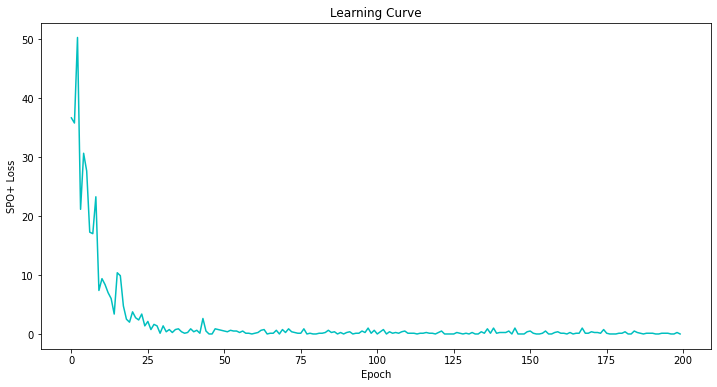

In [47]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

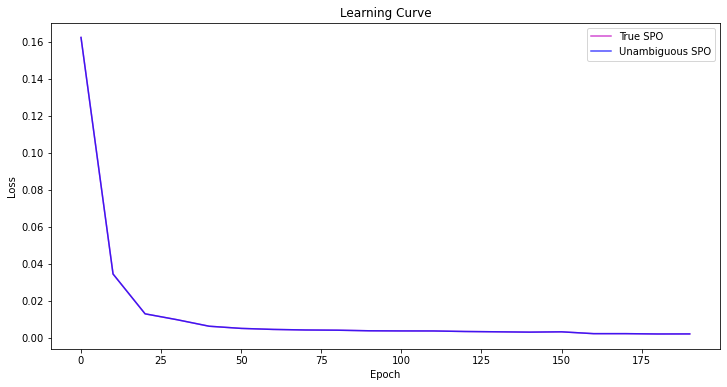

In [48]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [49]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.21%
Normalized unambiguous SPO Loss: 0.21%


In [50]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: 2.73, 7.06, 13.91, 2.73, 6.00, 10.63, 7.79, 10.89, 6.59, 7.06, 10.01, 3.78, 10.63, 13.83, 2.73, 13.16, 7.88, 7.27, 13.16, 7.88, 6.59, 13.91, 13.16, 3.96, 5.43, 7.06, 3.96, 2.73, 7.06, 17.33, 7.10, 9.77, 10.82, 11.26, 14.18, 14.32, 1.56, 5.43, 1.56, 17.33, 5.43, 6.00, 10.01, 0.43, 2.73, 5.43, 17.33, 8.19
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

Sample

## Black-Box with Regularization 

In [51]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [52]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [53]:
# set loss
criterion = nn.L1Loss()

In [54]:
# train model
num_epochs = 200
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = spo.func.blackboxOpt.apply(ks_model, cp, lambd)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  14.3163, True SPO Loss: 16.1548%, Unambiguous SPO Loss: 16.1548%
Epoch  20, Loss:   3.4749, True SPO Loss:  2.6064%, Unambiguous SPO Loss:  2.6064%
Epoch  30, Loss:   0.5574, True SPO Loss:  1.0377%, Unambiguous SPO Loss:  1.0377%
Epoch  40, Loss:   0.7366, True SPO Loss:  0.6356%, Unambiguous SPO Loss:  0.6356%
Epoch  50, Loss:   1.4042, True SPO Loss:  0.5145%, Unambiguous SPO Loss:  0.5145%
Epoch  60, Loss:   0.6851, True SPO Loss:  0.4409%, Unambiguous SPO Loss:  0.4409%
Epoch  70, Loss:   0.9882, True SPO Loss:  0.3943%, Unambiguous SPO Loss:  0.3943%
Epoch  80, Loss:   0.4045, True SPO Loss:  0.3914%, Unambiguous SPO Loss:  0.3914%
Epoch  90, Loss:   0.8076, True SPO Loss:  0.3265%, Unambiguous SPO Loss:  0.3265%
Epoch 100, Loss:   0.5144, True SPO Loss:  0.2897%, Unambiguous SPO Loss:  0.2897%
Epoch 110, Loss:   0.2388, True SPO Loss:  0.2936%, Unambiguous SPO Loss:  0.2936%
Epoch 120, Loss:   0.5095, True SPO Loss:  0.3023%, Unambiguous SPO Loss:  0.3023%
Epoc

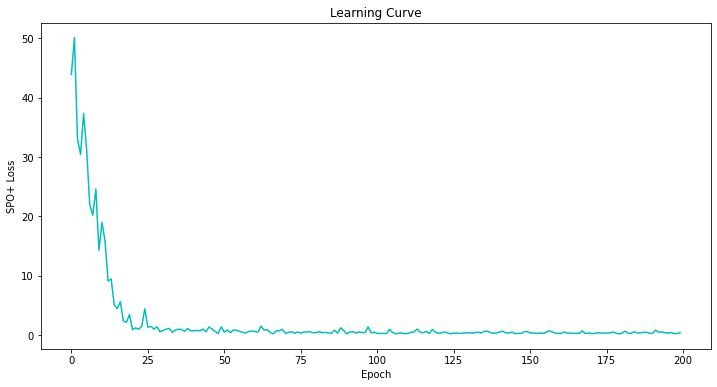

In [55]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

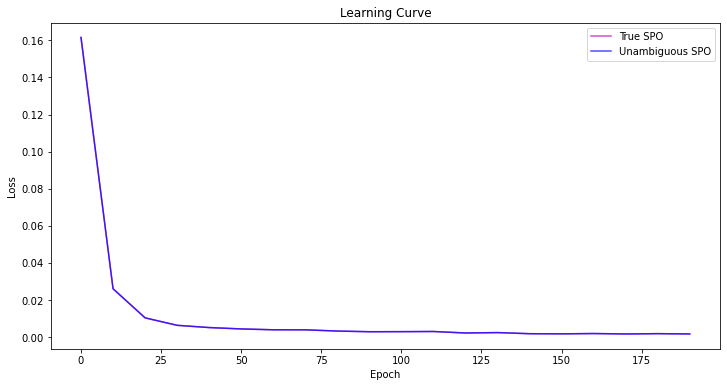

In [56]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [57]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.17%
Normalized unambiguous SPO Loss: 0.17%


In [58]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: 2.73, 7.06, 13.91, 2.73, 6.00, 10.63, 7.79, 10.89, 6.59, 7.06, 10.01, 3.78, 10.63, 13.83, 2.73, 13.16, 7.88, 7.27, 13.16, 7.88, 6.59, 13.91, 13.16, 3.96, 5.43, 7.06, 3.96, 2.73, 7.06, 17.33, 7.10, 9.77, 10.82, 11.26, 14.18, 14.32, 1.56, 5.43, 1.56, 17.33, 5.43, 6.00, 10.01, 0.43, 2.73, 5.43, 17.33, 8.19
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

Sample